In [1]:
!pip install torch torchvision transformers


In [2]:
# Create the .kaggle directory for API credentials
!mkdir ~/.kaggle

# Copy the kaggle.json file to the appropriate location
!cp kaggle.json ~/.kaggle/

# Set permissions on the kaggle.json file
!chmod 600 ~/.kaggle/kaggle.json

# Download the APTOS 2019 dataset from Kaggle
!kaggle datasets download -d mariaherrerot/aptos2019

# Unzip the downloaded dataset
!unzip aptos2019.zip -d ./aptos2019


Dataset URL: https://www.kaggle.com/datasets/mariaherrerot/aptos2019
License(s): unknown
100% 8.00G/8.01G [01:49<00:00, 44.0MB/s]
100% 8.01G/8.01G [01:49<00:00, 78.4MB/s]
Archive:  aptos2019.zip
  inflating: ./aptos2019/test.csv    
  inflating: ./aptos2019/test_images/test_images/e4dcca36ceb4.png  
  inflating: ./aptos2019/test_images/test_images/e4e343eaae2a.png  
  inflating: ./aptos2019/test_images/test_images/e4f12411fd85.png  
  inflating: ./aptos2019/test_images/test_images/e50b0174690d.png  
  inflating: ./aptos2019/test_images/test_images/e5197d77ec68.png  
  inflating: ./aptos2019/test_images/test_images/e529c5757d64.png  
  inflating: ./aptos2019/test_images/test_images/e52ed5c29c5e.png  
  inflating: ./aptos2019/test_images/test_images/e540d2e35d15.png  
  inflating: ./aptos2019/test_images/test_images/e55188915f9d.png  
  inflating: ./aptos2019/test_images/test_images/e580676516b0.png  
  inflating: ./aptos2019/test_images/test_images/e582e56e7942.png  
  inflating: ./apto

In [3]:
import os
import pandas as pd
from PIL import Image
from torchvision import transforms
import torch
from torch.utils.data import DataLoader, Dataset

# Define the custom Dataset class for diabetic retinopathy data
class DiabeticRetinopathyDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        """
        df: DataFrame containing image names and labels
        img_dir: Directory where images are stored
        transform: Image transformations to apply (resize, normalize, etc.)
        """
        self.df = df
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # Fetch the image name and its corresponding label from the DataFrame
        img_name = self.df.iloc[idx, 0] + '.png'  # Assuming first column is image name (without extension)
        img_path = os.path.join(self.img_dir, img_name)

        # Load the image
        if os.path.exists(img_path):
            image = Image.open(img_path).convert('RGB')  # Open the image
        else:
            raise FileNotFoundError(f"Image {img_path} not found.")

        # Fetch the label (assuming second column is the label)
        label = self.df.iloc[idx, 1]

        # Apply transformations, if any
        if self.transform:
            image = self.transform(image)

        return image, label

# Define transformations (Resize and normalize for Vision Transformer)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Vision Transformer input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the CSVs for training, validation, and testing
data_path = "./aptos2019"
train_df = pd.read_csv(os.path.join(data_path, 'train_1.csv'))  # Training CSV
val_df = pd.read_csv(os.path.join(data_path, 'valid.csv'))      # Validation CSV
test_df = pd.read_csv(os.path.join(data_path, 'test.csv'))      # Test CSV

# Create dataset instances for train, validation, and test sets
train_dataset = DiabeticRetinopathyDataset(train_df, os.path.join(data_path, 'train_images/train_images'), transform=transform)
val_dataset = DiabeticRetinopathyDataset(val_df, os.path.join(data_path, 'val_images/val_images'), transform=transform)
test_dataset = DiabeticRetinopathyDataset(test_df, os.path.join(data_path, 'test_images/test_images'), transform=transform)

# Create DataLoaders for batch processing
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Print out dataset sizes for verification
print(f"Training samples: {len(train_loader.dataset)}")
print(f"Validation samples: {len(val_loader.dataset)}")
print(f"Test samples: {len(test_loader.dataset)}")


Training samples: 2930
Validation samples: 366
Test samples: 366


In [4]:
from transformers import ViTForImageClassification, ViTFeatureExtractor
import torch
from torch import nn
from torch.optim import Adam
from torch.utils.data import DataLoader

# Check if GPU is available, otherwise fallback to CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the pre-trained Vision Transformer (ViT) model
model = ViTForImageClassification.from_pretrained(
    'google/vit-base-patch16-224-in21k',
    num_labels=5  # 5 classes for diabetic retinopathy
)

# Move the model to the available device (GPU/CPU)
model.to(device)

# Optimizer and loss function
optimizer = Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

# Training function
def train_model(model, train_loader, val_loader, epochs=5):
    for epoch in range(epochs):
        model.train()  # Set model to training mode
        train_loss = 0
        correct = 0
        total = 0

        # Training loop
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images).logits
            loss = criterion(outputs, labels)
            loss.backward()  # Backward pass
            optimizer.step()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_accuracy = 100 * correct / total
        print(f"Epoch {epoch+1}/{epochs}, Loss: {train_loss / len(train_loader)}, Accuracy: {train_accuracy}")

        # Validation loop
        model.eval()  # Set model to evaluation mode
        val_loss = 0
        correct = 0
        total = 0

        with torch.no_grad():  # No need to compute gradients for validation
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)

                outputs = model(images).logits
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        val_accuracy = 100 * correct / total
        print(f"Validation Loss: {val_loss / len(val_loader)}, Validation Accuracy: {val_accuracy}")

# Load the dataset again with correct paths
train_df = pd.read_csv(os.path.join(data_path, 'train_1.csv'))  # Training CSV
val_df = pd.read_csv(os.path.join(data_path, 'valid.csv'))      # Validation CSV

# Create dataset instances for train and validation sets
train_dataset = DiabeticRetinopathyDataset(train_df, os.path.join(data_path, 'train_images/train_images'), transform=transform)
val_dataset = DiabeticRetinopathyDataset(val_df, os.path.join(data_path, 'val_images/val_images'), transform=transform)

# Create DataLoaders for batch processing
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Train the model for 5 epochs
train_model(model, train_loader, val_loader, epochs=5)

# Save the trained model
model_save_path = "diabetic_retinopathy_vit_model.pth"
torch.save(model.state_dict(), model_save_path)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5, Loss: 0.7962400751269382, Accuracy: 72.79863481228669
Validation Loss: 0.6402479236324629, Validation Accuracy: 77.8688524590164
Epoch 2/5, Loss: 0.5548821771922319, Accuracy: 80.06825938566553
Validation Loss: 0.5054032405217489, Validation Accuracy: 82.78688524590164
Epoch 3/5, Loss: 0.4378560012125451, Accuracy: 84.19795221843003
Validation Loss: 0.5758427505691847, Validation Accuracy: 77.59562841530055
Epoch 4/5, Loss: 0.38244573933922726, Accuracy: 86.79180887372014
Validation Loss: 0.4714139886200428, Validation Accuracy: 83.33333333333333
Epoch 5/5, Loss: 0.27508893609046936, Accuracy: 91.160409556314
Validation Loss: 0.494049238661925, Validation Accuracy: 83.06010928961749


In [6]:
import torch
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Load the saved model
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k', num_labels=5)
model.load_state_dict(torch.load("diabetic_retinopathy_vit_model.pth", map_location=torch.device('cpu')))
model.eval()

# Initialize lists to store true labels and predictions
all_preds = []
all_labels = []

# Move model to CPU (or GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# No gradient computation required for evaluation
with torch.no_grad():
    for images, labels in test_loader:  # Assuming test_loader is already defined
        images, labels = images.to(device), labels.to(device)
        outputs = model(images).logits
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Convert lists to arrays for easier metric computation
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Step 2: Calculate accuracy
test_accuracy = accuracy_score(all_labels, all_preds)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-6-bc854b2e4fb4>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_global

Test Accuracy: 82.24%


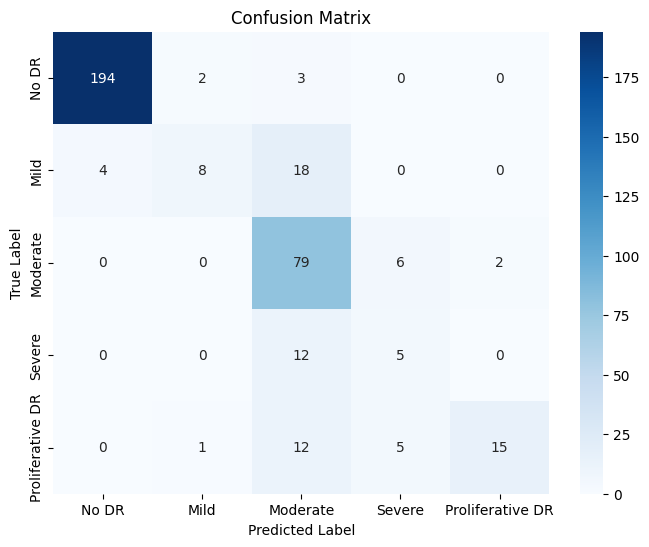

In [7]:
# Generate confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Define class names
class_names = ["No DR", "Mild", "Moderate", "Severe", "Proliferative DR"]

# Plot the confusion matrix using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


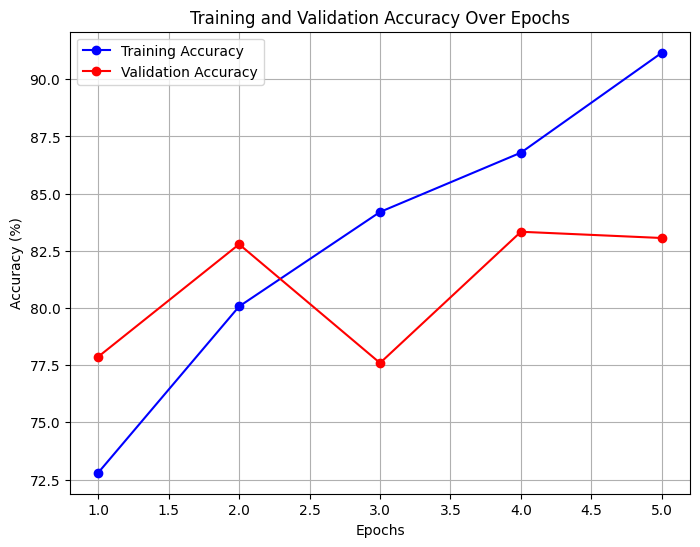

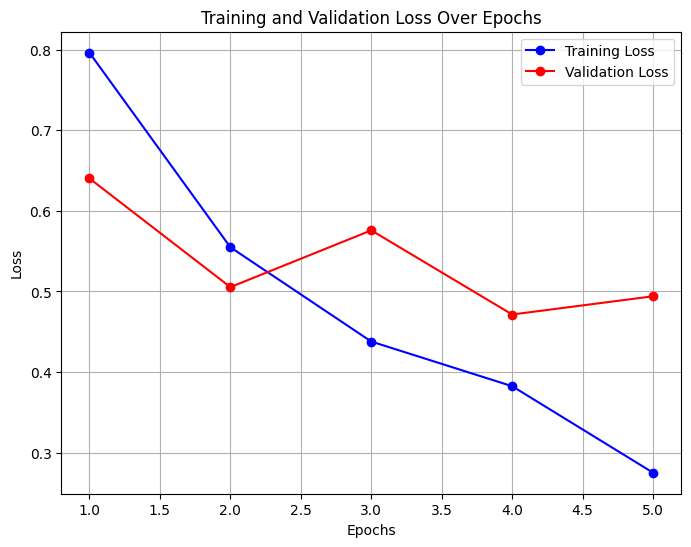

In [8]:
import matplotlib.pyplot as plt

# Data provided from the output of training
epochs = range(1, 6)  # 5 epochs
train_acc = [72.79863481228669, 80.06825938566553, 84.19795221843003, 86.79180887372014, 91.160409556314]  # Training Accuracy
val_acc = [77.8688524590164, 82.78688524590164, 77.59562841530055, 83.33333333333333, 83.06010928961749]  # Validation Accuracy

train_loss = [0.7962400751269382, 0.5548821771922319, 0.4378560012125451, 0.38244573933922726, 0.27508893609046936]  # Training Loss
val_loss = [0.6402479236324629, 0.5054032405217489, 0.5758427505691847, 0.4714139886200428, 0.494049238661925]  # Validation Loss

# Plot accuracy over epochs
plt.figure(figsize=(8, 6))
plt.plot(epochs, train_acc, 'b', label='Training Accuracy', marker='o')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.show()

# Plot loss over epochs
plt.figure(figsize=(8, 6))
plt.plot(epochs, train_loss, 'b', label='Training Loss', marker='o')
plt.plot(epochs, val_loss, 'r', label='Validation Loss', marker='o')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()
